In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
AirData_16to19_Df = pd.read_csv(r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData.csv",usecols=['Stop', 'Station Name', 'NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'Classification', 'PM10'])

In [3]:
# Rename Stop to Time
AirData_16to19_Df = AirData_16to19_Df.rename(columns={"Stop": "Timestamp"})
# convert columns to date
AirData_16to19_Df['Timestamp'] = pd.to_datetime(AirData_16to19_Df['Timestamp'])
AirData_16to19_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450646 entries, 0 to 450645
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       450646 non-null  datetime64[ns]
 1   Station Name    450646 non-null  object        
 2   NO2             445087 non-null  float64       
 3   NOX as NO2      445450 non-null  float64       
 4   PM2.5           183966 non-null  float64       
 5   CO              253349 non-null  float64       
 6   Black Carbon    55003 non-null   float64       
 7   O3              75291 non-null   float64       
 8   Classification  450646 non-null  object        
 9   PM10            267321 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 34.4+ MB


In [4]:
AirData_16to19_Df.describe()

,NO2,NOX as NO2,PM2.5,CO,Black Carbon,O3,PM10
count,445087.000000,445450.000000,183966.000000,253349.000000,55003.000000,75291.000000,267321.000000
mean,26.403201,52.154674,5.672138,0.297422,0.650116,44.094675,18.960425
std,21.326453,60.688404,4.678776,0.233166,0.637904,21.941151,19.918945
min,-0.300000,-0.500000,-3.000000,0.000000,0.000000,0.100000,-3.040000
25%,10.100000,13.000000,2.600000,0.200000,0.209000,28.000000,8.000000
50%,20.300000,29.900000,4.600000,0.270000,0.444000,43.300000,13.400000
75%,37.200000,68.500000,7.400000,0.350000,0.891000,59.000000,22.400000
max,221.700000,1324.000000,105.000000,20.700000,30.400000,151.200000,447.600000


## 1) Feature selection

In [5]:
# Percentage of empty rows in each pollutant
total = AirData_16to19_Df.isnull().sum().sort_values(ascending = False)
print("Empty rows in each pollutant:")
total / len(AirData_16to19_Df) * 100

Empty rows in each pollutant:


Black Carbon      87.794633
O3                83.292651
PM2.5             59.177270
CO                43.780928
PM10              40.680490
NO2                1.233562
NOX as NO2         1.153011
Classification     0.000000
Station Name       0.000000
Timestamp          0.000000
dtype: float64

In [6]:
# Percentage of Non-zero or Non-negative rows in each pollutant
total = (AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']] >= 0).sum().sort_values(ascending = True)
print("Non-zero or Non-negative rows in each pollutant:")
total / len(AirData_16to19_Df) * 100

Non-zero or Non-negative rows in each pollutant:


Black Carbon    12.205367
O3              16.707349
PM2.5           39.737177
CO              56.219072
PM10            59.015946
NO2             98.766216
NOX as NO2      98.846323
dtype: float64

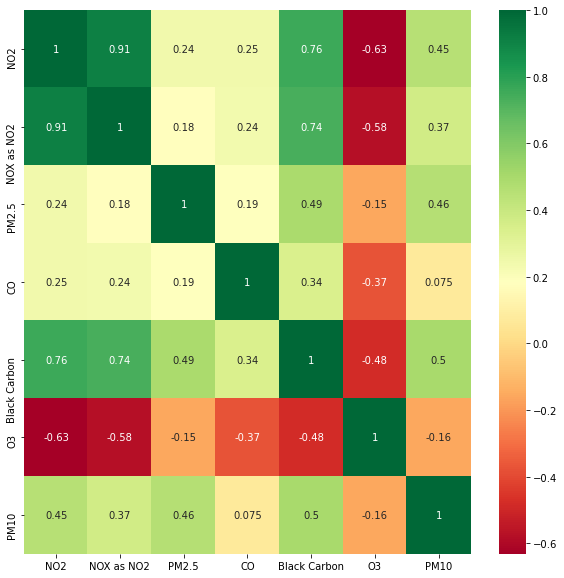

In [7]:
# correlation Matrix with Heatmap
# get correlations of each features in dataset
corrmat = AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# plot heat map
g=sns.heatmap(AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']][top_corr_features].corr(),annot=True,cmap="RdYlGn")

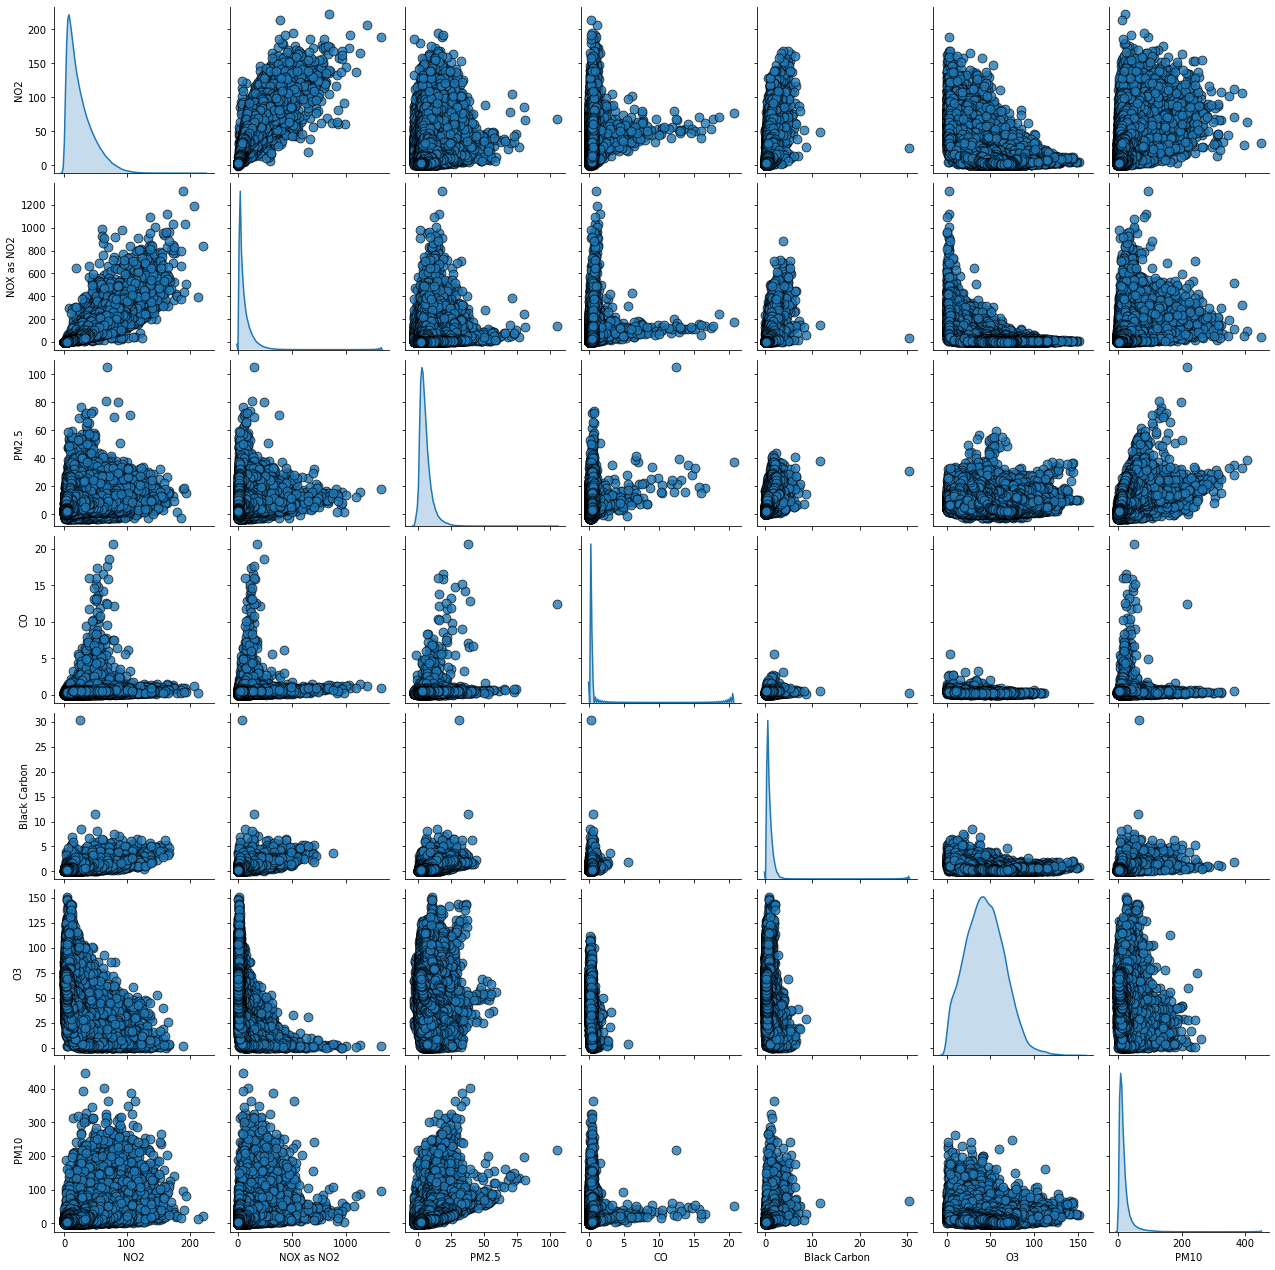

In [8]:
sns.pairplot(AirData_16to19_Df, diag_kind="kde", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'})

### Features Selected Based On Above analysis: 
#### 'NO2', 'NOX as NO2', 'PM2.5', 'PM10'

In [9]:
# updating data
AirData_1 = AirData_16to19_Df[['Timestamp', 'Station Name', 'Classification', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
AirData_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450646 entries, 0 to 450645
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       450646 non-null  datetime64[ns]
 1   Station Name    450646 non-null  object        
 2   Classification  450646 non-null  object        
 3   NO2             445087 non-null  float64       
 4   NOX as NO2      445450 non-null  float64       
 5   PM2.5           183966 non-null  float64       
 6   PM10            267321 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 24.1+ MB


## 2) Station Selection

In [10]:
# Generating Year and droppng 2020 data
AirData_1['Year'] = AirData_1['Timestamp'].dt.year
# drop 2020 data
AirData_1 = AirData_1[AirData_1['Year'] !=  2020]
AirData_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450635 entries, 0 to 450644
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       450635 non-null  datetime64[ns]
 1   Station Name    450635 non-null  object        
 2   Classification  450635 non-null  object        
 3   NO2             445076 non-null  float64       
 4   NOX as NO2      445439 non-null  float64       
 5   PM2.5           183961 non-null  float64       
 6   PM10            267314 non-null  float64       
 7   Year            450635 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 30.9+ MB


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# Data distribution for selecting station
stationSelectGroups = AirData_1.groupby(['Year', 'Station Name']).aggregate('count').drop(['Timestamp','Classification'],1)
stationSelectGroups

NO2  NOX as NO2  PM2.5  PM10
Year Station Name                                                    
2015 #Stockholm E4/E20 Lilla Essingen   8674        8675   8629  8683
     #Stockholm Hornsgatan 108 Gata     8676        8676   8752  8716
     #Stockholm Hornsgatan 108 Tak      8670        8681      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8673        8675      0     0
     #Stockholm Norrlandsgatan 29       8513        8512      0  8486
     #Stockholm Sveavägen 59 Gata       8751        8751   8460  8642
     #Stockholm Sveavägen 59 Tak        8751        8751      0     0
     #Stockholm Sveavägen 88 Gata       8752        8752      0     0
     #Stockholm Torkel Knutssongatan    8677        8677   8479  8075
2016 #Stockholm E4/E20 Lilla Essingen   8737        8738   8562  8612
     #Stockholm Folkungagatan 57        7764        7764      0  7704
     #Stockholm Hornsgatan 108 Gata     8709        8712   8763  8658
     #Stockholm Hornsgatan 108 Tak      8716        8728      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8723        8724      0     0
     #Stockholm Norrlandsgatan 29       8779        8780      0  8761
     #Stockholm Sveavägen 59 Gata       8756        8759   8414  8630
     #Stockholm Sveavägen 59 Tak        8737        8759      0     0
     #Stockholm Sveavägen 88 Gata       8757        8759      0     0
     #Stockholm Torkel Knutssongatan    8746        8747   8738  8552
2017 #Stockholm E4 Skonertvägen         4685        4689      0  4644
     #Stockholm E4/E20 Lilla Essingen   8741        8742   8593  8654
     #Stockholm Folkungagatan 57        8628        8628      0  8620
     #Stockholm Hornsgatan 108 Gata     8661        8664   8517  8359
     #Stockholm Hornsgatan 108 Tak      8639        8645      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8657        8665      0     0
     #Stockholm Norrlandsgatan 29       8661        8662      0  8546
     #Stockholm Sveavägen 59 Gata       8712        8735   7058  7367
     #Stockholm Sveavägen 59 Tak        8709        8736      0     0
     #Stockholm Sveavägen 88 Gata       8736        8735      0     0
     #Stockholm Torkel Knutssongatan    8725        8726   8716  8564
2018 #Stockholm E4 Skonertvägen         8752        8755      0  8693
     #Stockholm E4/E20 Lilla Essingen   8587        8587   8452  8546
     #Stockholm Folkungagatan 57        1453        1453      0  1450
     #Stockholm Folkungagatan 70        6533        6548      0  6477
     #Stockholm Hornsgatan 108 Gata     8663        8695   8252  7750
     #Stockholm Hornsgatan 108 Tak      8706        8709      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8701        8707      0     0
     #Stockholm Norrlandsgatan 29          1           1      0     1
     #Stockholm St Eriksgatan 83        8456        8456   8699  8699
     #Stockholm Sveavägen 59 Gata       8628        8633   7438  8553
     #Stockholm Sveavägen 59 Tak        8657        8690      0     0
     #Stockholm Sveavägen 88 Gata       8685        8697      0     0
     #Stockholm Torkel Knutssongatan    8572        8573   8636  8450
2019 #Stockholm E4 Skonertvägen         8449        8437      0  8634
     #Stockholm E4/E20 Lilla Essingen   8685        8662   8429  8528
     #Stockholm Folkungagatan 70        8721        8725      0  8657
     #Stockholm Hornsgatan 108 Gata     8711        8685   8755  8755
     #Stockholm Hornsgatan 108 Tak      8735        8735      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8654        8660      0     0
     #Stockholm St Eriksgatan 83        8572        8571   8704  8704
     #Stockholm Sveavägen 59 Gata       8392        8557   8546  8673
     #Stockholm Sveavägen 59 Tak        8324        8332      0     0
     #Stockholm Sveavägen 88 Gata       8625        8625      0     0
     #Stockholm Torkel Knutssongatan    8699        8699   6369  8471

In [12]:
# filtering stations based on data avaliable (Greater than 0 on all selected pollutants across year)
print("Combinations:")
print(stationSelectGroups[stationSelectGroups.all(1)].index)
print("Stations:")
print(stationSelectGroups[stationSelectGroups.all(1)].index.unique(1))

Combinations:
MultiIndex([(2015, '#Stockholm E4/E20 Lilla Essingen'),
            (2015,   '#Stockholm Hornsgatan 108 Gata'),
            (2015,     '#Stockholm Sveavägen 59 Gata'),
            (2015,  '#Stockholm Torkel Knutssongatan'),
            (2016, '#Stockholm E4/E20 Lilla Essingen'),
            (2016,   '#Stockholm Hornsgatan 108 Gata'),
            (2016,     '#Stockholm Sveavägen 59 Gata'),
            (2016,  '#Stockholm Torkel Knutssongatan'),
            (2017, '#Stockholm E4/E20 Lilla Essingen'),
            (2017,   '#Stockholm Hornsgatan 108 Gata'),
            (2017,     '#Stockholm Sveavägen 59 Gata'),
            (2017,  '#Stockholm Torkel Knutssongatan'),
            (2018, '#Stockholm E4/E20 Lilla Essingen'),
            (2018,   '#Stockholm Hornsgatan 108 Gata'),
            (2018,      '#Stockholm St Eriksgatan 83'),
            (2018,     '#Stockholm Sveavägen 59 Gata'),
            (2018,  '#Stockholm Torkel Knutssongatan'),
            (2019, '#Stockholm E4/

### Stations Selected:
#### 2016 - 2019:
##### 1.Stockholm E4/E20 Lilla Essingen, 2.Stockholm Hornsgatan 108 Gata, 3.Stockholm Sveavägen 59 Gata, 4.Stockholm Torkel Knutssongatan
#### 2018 - 2019: 
##### 1.Stockholm E4/E20 Lilla Essingen, 2.Stockholm Hornsgatan 108 Gata, 3.Stockholm St Eriksgatan 83, 4.Stockholm Sveavägen 59 Gata, 5.Stockholm Torkel Knutssongatan

In [13]:
# updating data
AirData_2 = AirData_1.loc[(AirData_1['Station Name'] == "#Stockholm E4/E20 Lilla Essingen") |
                          (AirData_1['Station Name'] == "#Stockholm Hornsgatan 108 Gata") | 
                          (AirData_1['Station Name'] == "#Stockholm Sveavägen 59 Gata") | 
                          (AirData_1['Station Name'] == "#Stockholm Torkel Knutssongatan")].drop('Year',1)

print(AirData_2['Station Name'].unique())
print("\n")
print(AirData_2.info())

['#Stockholm E4/E20 Lilla Essingen' '#Stockholm Sveavägen 59 Gata'
 '#Stockholm Hornsgatan 108 Gata' '#Stockholm Torkel Knutssongatan']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 8.6+ MB
None


## 3) Outliers Removal

In [14]:
# Generating weektype from day of week
AirData_2['Weektype'] = pd.DatetimeIndex(AirData_2['Timestamp']).dayofweek
# Replace weedays labels WeekDays and WeekEnds 
AirData_2['Weektype'] = AirData_2['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
AirData_2['Weektype'] = AirData_2['Weektype'].replace([5, 6], 'WeekEnd')
print(AirData_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
 7   Weektype        140252 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 9.6+ MB
None


In [15]:
# Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
AirData_2 = AirData_2.assign(Hour=pd.cut(AirData_2['Timestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
# Replace timestamp 00:00 with Transition
AirData_2['Hour'] = AirData_2['Hour'].fillna('Transition')
AirData_2['Hour'] = AirData_2.Hour.astype(str)

In [16]:
AirData_2.groupby(['Classification','Weektype','Hour']).count().drop(['Timestamp'],1)

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               4172   4131        4131   3859   
                          Peak                9387   9282        9282   8692   
                          Traffic             7301   7222        7222   6764   
                          Transition          4171   4131        4131   3861   
                 WeekEnd  Night               1672   1657        1658   1545   
                          Peak                3762   3745        3745   3481   
                          Traffic             2926   2912        2912   2709   
                          Transition          1672   1662        1663   1547   
Urban Traffic    WeekDay  Night              12516  12256       12308  11920   
                          Peak               28161  27858       27888  26516   
                          Traffic            21903  21677       21694  20777   
                          Transition         12513  12400       12417  11921   
                 WeekEnd  Night               5016   4907        4924   4779   
                          Peak               11286  11201       11220  10701   
                          Traffic             8778   8711        8727   8361   
                          Transition          5016   4972        4988   4802   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        4050  
                          Peak         9036  
                          Traffic      7064  
                          Transition   4048  
                 WeekEnd  Night        1645  
                          Peak         3685  
                          Traffic      2863  
                          Transition   1646  
Urban Traffic    WeekDay  Night       12062  
                          Peak        26884  
                          Traffic     21048  
                          Transition  12056  
                 WeekEnd  Night        4842  
                          Peak        10873  
                          Traffic      8471  
                          Transition   4849

In [17]:
AirData_2.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.3    4.3   70.9        0.5    5.1   
                          Peak        0.9   10.2   83.7        1.6   12.5   
                          Traffic     0.7   12.6   92.2        1.3   14.6   
                          Transition  0.4    6.1   82.8        1.1    7.0   
                 WeekEnd  Night       0.5    4.5   94.2        0.9    5.3   
                          Peak        0.5    5.9   81.1        1.4    7.3   
                          Traffic     0.3    5.7   70.1        1.0    6.9   
                          Transition  0.4    5.6   91.3        0.9    6.5   
Urban Traffic    WeekDay  Night       0.3   12.9   98.8        0.1   19.8   
                          Peak        2.0   41.5  180.2        2.1   87.7   
                          Traffic     2.4   42.6  212.8        2.6   87.8   
                          Transition  0.8   20.2  121.9        0.9   33.1   
                 WeekEnd  Night       0.6   15.6  120.8        1.9   23.5   
                          Peak        2.0   27.7  130.1        2.8   51.1   
                          Traffic     0.6   23.7  158.8        1.3   40.1   
                          Transition  1.0   20.2  121.6        1.0   31.7   

                                            PM2.5               PM10         \
                                        max   min median    max  min median   
Classification   Weektype Hour                                                
Urban Background WeekDay  Night       118.6   0.1    3.4   34.7 -3.0    7.4   
                          Peak        647.0   0.3    3.4   38.6 -2.9   10.7   
                          Traffic     341.8   0.2    3.6   36.0 -3.0   10.7   
                          Transition  155.5   0.2    3.5   36.5 -2.9    8.4   
                 WeekEnd  Night       237.4   0.4    3.6   39.0 -3.0    7.7   
                          Peak        165.2   0.2    3.3   59.3 -2.8    8.7   
                          Traffic     239.5   0.3    3.4   54.5 -3.0    8.6   
                          Transition  159.0   0.2    3.8   47.6 -1.8    8.2   
Urban Traffic    WeekDay  Night       573.4  -3.0    3.9   39.3 -2.9   10.3   
                          Peak        926.8  -3.0    5.4   80.1 -2.2   20.2   
                          Traffic     882.0  -3.0    5.5   61.6 -2.9   18.9   
                          Transition  982.5  -3.0    4.6   71.2 -3.0   13.0   
                 WeekEnd  Night       371.8  -3.0    4.5   42.0 -1.1   11.4   
                          Peak        375.8  -3.0    4.8  105.0 -1.8   15.5   
                          Traffic     488.6  -3.0    4.8   57.8 -2.5   13.5   
                          Transition  379.9  -3.0    5.1   72.4 -2.2   12.9   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        73.3  
                          Peak        162.6  
                          Traffic     148.0  
                          Transition   76.9  
                 WeekEnd  Night        69.6  
                          Peak        140.4  
                          Traffic      94.0  
                          Transition   71.8  
Urban Traffic    WeekDay  Night       173.4  
                          Peak        324.8  
                          Traffic     365.1  
                          Transition  297.9  
                 WeekEnd  Night       208.1  
                          Peak        261.6  
                          Traffic     219.0  
                          Transition  186.8

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"


<AxesSubplot:xlabel='Timestamp'>

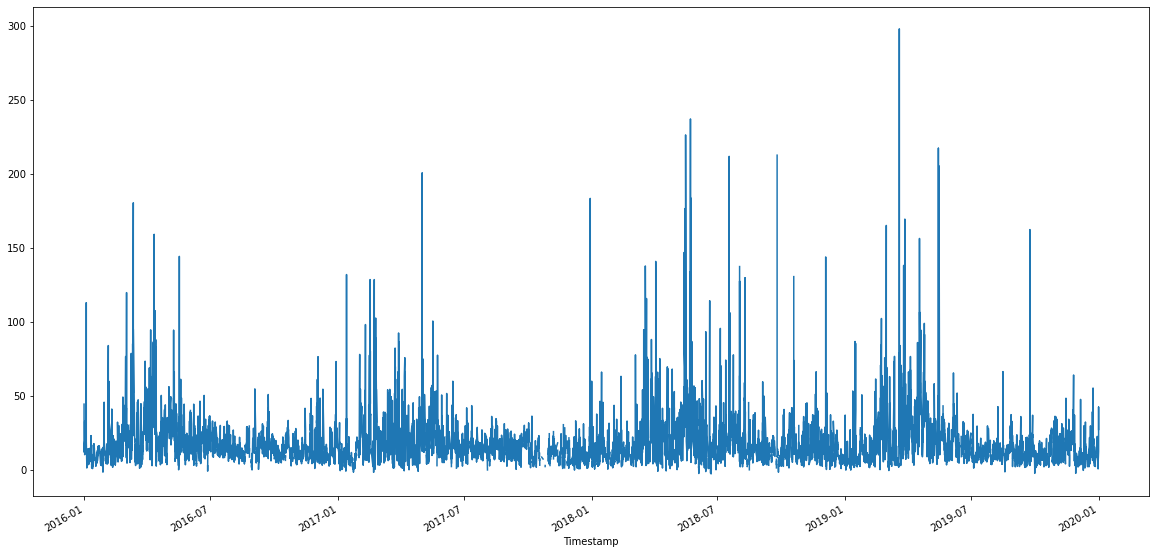

In [18]:
cfilt = list(AirData_2['Classification'].unique())
wfilt = list(AirData_2['Weektype'].unique())
hfilt = list(AirData_2['Hour'].unique())

# Time Series of IQR
temp = AirData_2.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
plot_data1 = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
plot_data1 = plot_data1.set_index("Timestamp")
plot_data1['PM10'].plot(figsize = (20,10))

### IQR Method

In [19]:
cfilt = list(AirData_2['Classification'].unique())
wfilt = list(AirData_2['Weektype'].unique())
hfilt = list(AirData_2['Hour'].unique())

AirData_3 = pd.DataFrame(columns = ['Timestamp', 'Station Name', 'Classification','Weektype', 'Hour', 'NO2', 'NOX as NO2',
       'PM2.5', 'PM10'])

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            print(len(AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
            temp = AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            
            # removing Outliers
            Q1 = temp['PM2.5'].quantile(0.25)
            Q3 = temp['PM2.5'].quantile(0.75)
            IQR = Q3 - Q1 
            IQR
            Outlier_filter = (temp['PM2.5'] >= Q1 - 1.5 * IQR) & (temp['PM2.5'] <= Q3 + 1.5 * IQR)
            temp = temp.loc[Outlier_filter]

            Q1 = temp['PM10'].quantile(0.25)
            Q3 = temp['PM10'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['PM10'] >= Q1 - 1.5 * IQR) & (temp['PM10'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]

            Q1 = temp['NO2'].quantile(0.25)
            Q3 = temp['NO2'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['NO2'] >= Q1 - 1.5 * IQR) & (temp['NO2'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]  

            Q1 = temp['NOX as NO2'].quantile(0.25)
            Q3 = temp['NOX as NO2'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['NOX as NO2'] >= Q1 - 1.5 * IQR) & (temp['NOX as NO2'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]    
            AirData_3 = AirData_3.append(temp)
            print('Appended\n')
            
print("Saving File")
savePath = r"G:\Uppsala Docs\period5&6\ProcessedData"
AirData_3.to_csv(savePath+"\\"+'2016-2019_SensorData_Outlier_Removed_IQR.csv')

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"
12513
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Night"
12516
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Traffic"
21903
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Peak"
28161
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
5016
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Night"
5016
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Traffic"
8778
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Peak"
11286
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
4171
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
4172
Appended

Classification == "Urban Background" & Weektype == "WeekDay" &

In [20]:
AirData_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107484 entries, 52242 to 371755
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       107484 non-null  datetime64[ns]
 1   Station Name    107484 non-null  object        
 2   Classification  107484 non-null  object        
 3   Weektype        107484 non-null  object        
 4   Hour            107484 non-null  object        
 5   NO2             107484 non-null  float64       
 6   NOX as NO2      107484 non-null  float64       
 7   PM2.5           107484 non-null  float64       
 8   PM10            107484 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 8.2+ MB


In [21]:
AirData_3.groupby(['Classification','Weektype','Hour']).count().drop(['Timestamp'],1)

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               3012   3012        3012   3012   
                          Peak                6706   6706        6706   6706   
                          Traffic             5362   5362        5362   5362   
                          Transition          3125   3125        3125   3125   
                 WeekEnd  Night               1251   1251        1251   1251   
                          Peak                2664   2664        2664   2664   
                          Traffic             2115   2115        2115   2115   
                          Transition          1280   1280        1280   1280   
Urban Traffic    WeekDay  Night               9903   9903        9903   9903   
                          Peak               21609  21609       21609  21609   
                          Traffic            17004  17004       17004  17004   
                          Transition          9999   9999        9999   9999   
                 WeekEnd  Night               3998   3998        3998   3998   
                          Peak                8661   8661        8661   8661   
                          Traffic             6748   6748        6748   6748   
                          Transition          4047   4047        4047   4047   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        3012  
                          Peak         6706  
                          Traffic      5362  
                          Transition   3125  
                 WeekEnd  Night        1251  
                          Peak         2664  
                          Traffic      2115  
                          Transition   1280  
Urban Traffic    WeekDay  Night        9903  
                          Peak        21609  
                          Traffic     17004  
                          Transition   9999  
                 WeekEnd  Night        3998  
                          Peak         8661  
                          Traffic      6748  
                          Transition   4047

In [22]:
AirData_3.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.3    3.8   11.6        0.8    4.6   
                          Peak        1.5    8.9   30.2        2.3   11.1   
                          Traffic     0.9   11.1   38.1        1.7   13.1   
                          Transition  0.4    5.5   17.2        1.1    6.4   
                 WeekEnd  Night       0.5    4.0   12.2        0.9    4.8   
                          Peak        0.6    5.0   15.4        1.5    6.3   
                          Traffic     0.3    4.9   16.7        1.0    6.0   
                          Transition  0.4    5.0   15.6        0.9    5.9   
Urban Traffic    WeekDay  Night       0.3   11.8   38.8        0.8   18.0   
                          Peak        2.0   38.8   99.0        2.1   80.0   
                          Traffic     2.4   39.4  100.3        2.6   79.9   
                          Transition  0.8   18.8   55.3        0.9   30.4   
                 WeekEnd  Night       0.6   14.1   45.8        1.9   20.9   
                          Peak        2.0   25.7   67.7        2.8   46.8   
                          Traffic     0.6   20.9   66.8        1.3   34.9   
                          Transition  1.0   18.2   56.5        1.0   28.4   

                                            PM2.5              PM10         \
                                        max   min median   max  min median   
Classification   Weektype Hour                                               
Urban Background WeekDay  Night        12.4   0.1    2.8  11.6 -3.0    6.5   
                          Peak         32.0   0.3    3.0  10.7 -2.9    9.6   
                          Traffic      40.2   0.2    3.1  11.2 -3.0    9.5   
                          Transition   18.0   0.2    3.1  12.0 -2.9    7.5   
                 WeekEnd  Night        12.9   0.4    3.2  12.3 -3.0    7.0   
                          Peak         16.3   0.2    2.8  10.8 -2.8    7.7   
                          Traffic      17.7   0.3    3.0  11.2 -3.0    7.6   
                          Transition   16.3   0.2    3.3  12.4 -1.8    7.6   
Urban Traffic    WeekDay  Night        62.5  -3.0    3.5  13.5 -2.9    9.4   
                          Peak        259.2  -3.0    4.9  15.9 -2.2   18.1   
                          Traffic     256.7  -3.0    5.1  15.9 -2.9   17.1   
                          Transition   98.3  -3.0    4.1  15.0 -3.0   11.8   
                 WeekEnd  Night        75.8  -3.0    4.0  14.6 -1.1   10.4   
                          Peak        137.3  -3.0    4.2  15.0 -0.9   13.7   
                          Traffic     123.0  -3.0    4.2  14.7 -0.9   11.9   
                          Transition   98.4  -3.0    4.6  15.8 -1.7   11.5   

                                            
                                       max  
Classification   Weektype Hour              
Urban Background WeekDay  Night       19.3  
                          Peak        29.2  
                          Traffic     28.0  
                          Transition  22.1  
                 WeekEnd  Night       19.1  
                          Peak        22.6  
                          Traffic     21.9  
                          Transition  20.4  
Urban Traffic    WeekDay  Night       28.2  
                          Peak        64.0  
                          Traffic     55.8  
                          Transition  36.5  
                 WeekEnd  Night       29.8  
                          Peak        47.4  
                          Traffic     39.4  
                          Transition  34.5

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"


<AxesSubplot:xlabel='Timestamp'>

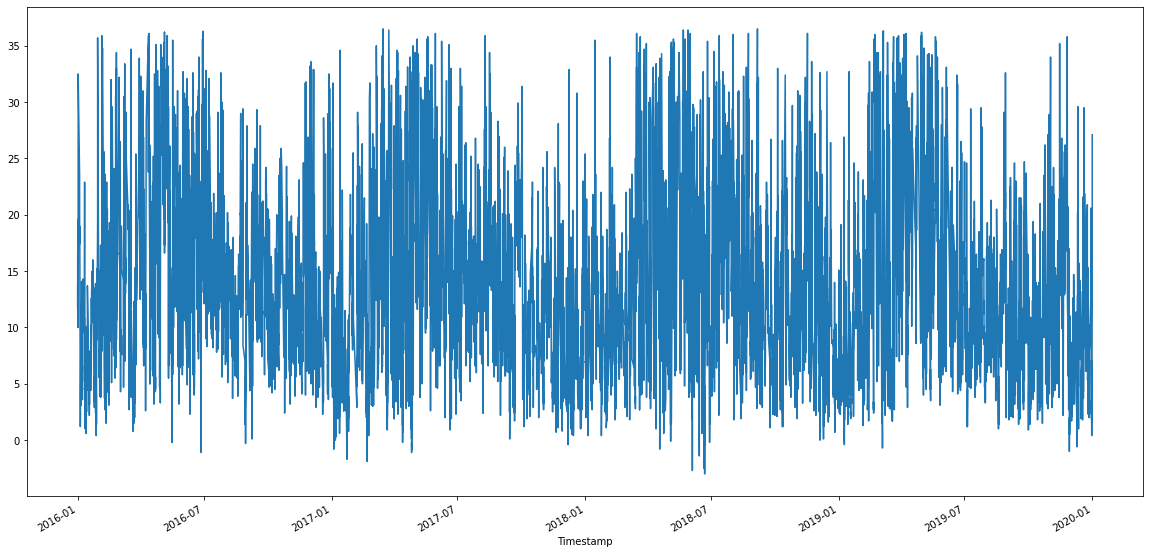

In [23]:
# Time Series of IQR
temp = AirData_3.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
plot_data1 = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
plot_data1 = plot_data1.set_index("Timestamp")
plot_data1['PM10'].plot(figsize = (20,10))

### Isolation Forest

In [24]:
nona_AirData_2 = AirData_2.fillna(0)

# IsolationForest parameter
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

cfilt = list(nona_AirData_2['Classification'].unique())
wfilt = list(nona_AirData_2['Weektype'].unique())
hfilt = list(nona_AirData_2['Hour'].unique())

nona_AirData_3 = pd.DataFrame(columns = ['Timestamp', 'Station Name', 'Classification','Weektype', 'Hour', 'NO2', 'NOX as NO2',
                                          'PM2.5', 'PM10'])

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            print(len(nona_AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
            temp = nona_AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            
            # removing Outliers
            to_model_columns=temp.columns[3:7]
            clf.fit(temp[to_model_columns])
            pred = clf.predict(temp[to_model_columns])
            temp['anomaly']=pred
            outliers=temp.loc[temp['anomaly']==-1]
            outlier_index=list(outliers.index)
            # number of anomalies(-1) and normal points(1)
            print(temp['anomaly'].value_counts())
            nona_AirData_3 = nona_AirData_3.append(temp)
            print('Appended\n')
            
print("Saving File")
savePath = r"G:\Uppsala Docs\period5&6\ProcessedData"
nona_AirData_3.to_csv(savePath+"\\"+'2016-2019_SensorData_Outlier_Removed_IF.csv')      

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"
12513


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    11011
-1     1502
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Night"
12516


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    11014
-1     1502
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Traffic"
21903


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    19274
-1     2629
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Peak"
28161


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    24781
-1     3380
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
5016


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    4414
-1     602
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Night"
5016


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    4414
-1     602
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Traffic"
8778


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    7724
-1    1054
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Peak"
11286


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    9931
-1    1355
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
4171


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    3670
-1     501
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
4172


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    3671
-1     501
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
7301


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    6425
-1     876
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
9387


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    8260
-1    1127
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Transition"
1672


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    1471
-1     201
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Night"
1672


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    1471
-1     201
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Traffic"
2926


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    2575
-1     351
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Peak"
3762


E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 1    3310
-1     452
Name: anomaly, dtype: int64
Appended

Saving File


In [25]:
nona_AirData_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371755
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   Weektype        140252 non-null  object        
 4   Hour            140252 non-null  object        
 5   NO2             140252 non-null  float64       
 6   NOX as NO2      140252 non-null  float64       
 7   PM2.5           140252 non-null  float64       
 8   PM10            140252 non-null  float64       
 9   anomaly         140252 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 11.8+ MB


In [26]:
nona_AirData_3.groupby(['Classification','Weektype','Hour']).count().drop(['Timestamp','anomaly'],1)

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               4172   4172        4172   4172   
                          Peak                9387   9387        9387   9387   
                          Traffic             7301   7301        7301   7301   
                          Transition          4171   4171        4171   4171   
                 WeekEnd  Night               1672   1672        1672   1672   
                          Peak                3762   3762        3762   3762   
                          Traffic             2926   2926        2926   2926   
                          Transition          1672   1672        1672   1672   
Urban Traffic    WeekDay  Night              12516  12516       12516  12516   
                          Peak               28161  28161       28161  28161   
                          Traffic            21903  21903       21903  21903   
                          Transition         12513  12513       12513  12513   
                 WeekEnd  Night               5016   5016        5016   5016   
                          Peak               11286  11286       11286  11286   
                          Traffic             8778   8778        8778   8778   
                          Transition          5016   5016        5016   5016   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        4172  
                          Peak         9387  
                          Traffic      7301  
                          Transition   4171  
                 WeekEnd  Night        1672  
                          Peak         3762  
                          Traffic      2926  
                          Transition   1672  
Urban Traffic    WeekDay  Night       12516  
                          Peak        28161  
                          Traffic     21903  
                          Transition  12513  
                 WeekEnd  Night        5016  
                          Peak        11286  
                          Traffic      8778  
                          Transition   5016

In [27]:
nona_AirData_3.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max']).drop(['anomaly'],1)

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.0    4.3   70.9        0.0    5.1   
                          Peak        0.0   10.1   83.7        0.0   12.4   
                          Traffic     0.0   12.5   92.2        0.0   14.5   
                          Transition  0.0    6.1   82.8        0.0    6.9   
                 WeekEnd  Night       0.0    4.4   94.2        0.0    5.2   
                          Peak        0.0    5.9   81.1        0.0    7.3   
                          Traffic     0.0    5.7   70.1        0.0    6.9   
                          Transition  0.0    5.6   91.3        0.0    6.4   
Urban Traffic    WeekDay  Night       0.0   12.6   98.8        0.0   19.4   
                          Peak        0.0   41.2  180.2        0.0   86.8   
                          Traffic     0.0   42.4  212.8        0.0   87.0   
                          Transition  0.0   20.1  121.9        0.0   32.8   
                 WeekEnd  Night       0.0   15.3  120.8        0.0   23.1   
                          Peak        0.0   27.6  130.1        0.0   50.8   
                          Traffic     0.0   23.5  158.8        0.0   39.9   
                          Transition  0.0   20.0  121.6        0.0   31.6   

                                            PM2.5               PM10         \
                                        max   min median    max  min median   
Classification   Weektype Hour                                                
Urban Background WeekDay  Night       118.6   0.0    3.1   34.7 -3.0   7.20   
                          Peak        647.0   0.0    3.2   38.6 -2.9  10.40   
                          Traffic     341.8   0.0    3.3   36.0 -3.0  10.40   
                          Transition  155.5   0.0    3.2   36.5 -2.9   8.20   
                 WeekEnd  Night       237.4   0.0    3.4   39.0 -3.0   7.60   
                          Peak        165.2   0.0    3.0   59.3 -2.8   8.55   
                          Traffic     239.5   0.0    3.2   54.5 -3.0   8.50   
                          Transition  159.0   0.0    3.5   47.6 -1.8   8.10   
Urban Traffic    WeekDay  Night       573.4  -3.0    3.7   39.3 -2.9   9.90   
                          Peak        926.8  -3.0    5.1   80.1 -2.2  19.30   
                          Traffic     882.0  -3.0    5.3   61.6 -2.9  18.30   
                          Transition  982.5  -3.0    4.4   71.2 -3.0  12.60   
                 WeekEnd  Night       371.8  -3.0    4.3   42.0 -1.1  11.10   
                          Peak        375.8  -3.0    4.5  105.0 -1.8  15.00   
                          Traffic     488.6  -3.0    4.6   57.8 -2.5  13.10   
                          Transition  379.9  -3.0    4.9   72.4 -2.2  12.50   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        73.3  
                          Peak        162.6  
                          Traffic     148.0  
                          Transition   76.9  
                 WeekEnd  Night        69.6  
                          Peak        140.4  
                          Traffic      94.0  
                          Transition   71.8  
Urban Traffic    WeekDay  Night       173.4  
                          Peak        324.8  
                          Traffic     365.1  
                          Transition  297.9  
                 WeekEnd  Night       208.1  
                          Peak        261.6  
                          Traffic     219.0  
                          Transition  186.8

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"


<AxesSubplot:xlabel='Timestamp'>

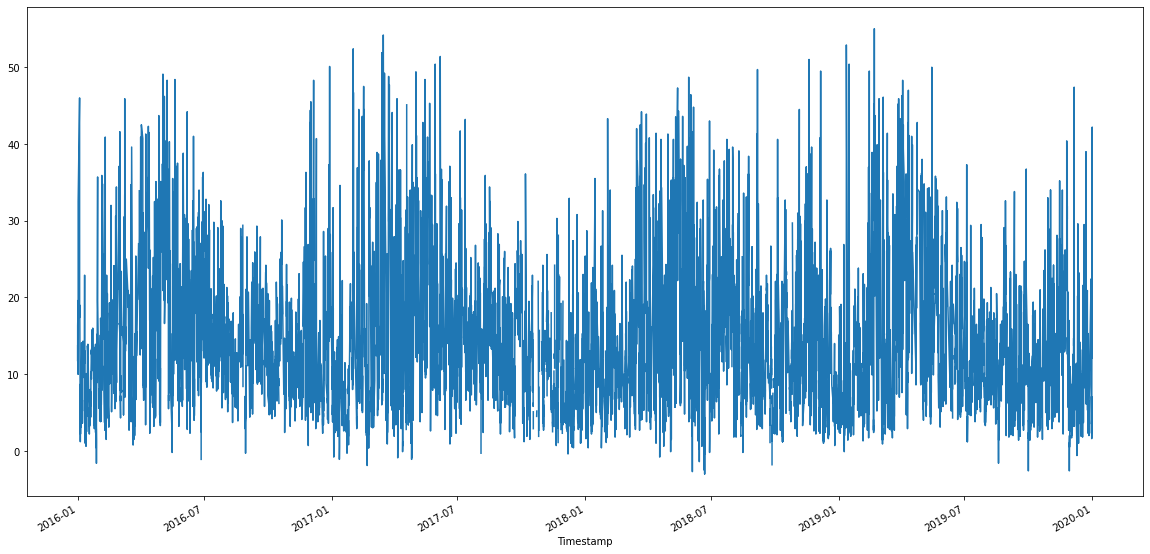

In [35]:
# Time Series of iF
temp = nona_AirData_3.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
plot_data1 = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10', 'anomaly']]
plot_data1 = plot_data1.set_index("Timestamp")
plot_data1.loc[plot_data1['anomaly'] == 1]['PM10'].plot(figsize = (20,10))

In [30]:
# replacing zeros with nan
iF_AirData_3 = nona_AirData_3
cols = ["NO2","NOX as NO2","PM2.5","PM10"]
iF_AirData_3[cols] = iF_AirData_3[cols].replace( 0, np.nan )

In [31]:
iF_AirData_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371755
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   Weektype        140252 non-null  object        
 4   Hour            140252 non-null  object        
 5   NO2             138724 non-null  float64       
 6   NOX as NO2      138910 non-null  float64       
 7   PM2.5           131960 non-null  float64       
 8   PM10            135064 non-null  float64       
 9   anomaly         140252 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 16.8+ MB


In [32]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [33]:
def plot_anomaly(df,metric_name):
    
    dates = df['Timestamp']
    
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) < 0)
    actuals = df["PM10"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 1] = np.nan
    
    #A dictionary for conditional format table based on anomaly
    color_map = {1: "rgb(228, 222, 249)", -1: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2],
    # columnorder=[0, 1, 2,],
    header=dict(height=20,
                values=[['<b>Date</b>'], ['<b>Actual Values </b>'],
                        ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be')),
    cells=dict(values=[df.round(3)[k].tolist() for k in ['Timestamp', 'PM10']],
               line=dict(color='#506784'),
               align=['center'] * 5,
               font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
               suffix=[None] + [''] + [''] + ['%'] + [''],
               height=27,
               fill=dict(color=[df['anomaly'].map(color_map)],#map based on anomaly level from dictionary
               )
               ))
    
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                     x=dates,
                     y=df['PM10'],
                     xaxis='x1', yaxis='y1',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=5,
                                           line=dict(color="red",width=1)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title='anomalies',#metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)

In [34]:
# Time Series of iF
temp = nona_AirData_3.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
plot_data1 = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10', 'anomaly']]
#plot_anomaly(plot_data1,'anomalies')

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"


In [1]:
pd.DataFrame(columns = ['Timestamp', 'Station Name', 'Classification','Weektype', 'Hour', 'NO2', 'NOX as NO2',
                                          'PM2.5', 'PM10'])

NameError: name 'pd' is not defined